<a href="https://colab.research.google.com/github/davidraamirez/GradientWithoutBackpropagation/blob/main/LogisticRegression_fwd_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary packages**


In [1]:
import torch
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

In [2]:
%pip install torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 8.6 MB/s eta 0:00:00


In [3]:
import torchmetrics
import torchvision

In [4]:
from torch import nn

In [5]:
from functorch import jvp
from functools import partial
import time 

In [6]:
import matplotlib.pyplot as plt

# **Loading and preprocessing the data**

In [7]:
#Load the dataset
penguins = tfds.load('penguins', as_supervised=True, split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteAB8LWL/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.


In [8]:
X, y = penguins.batch(500).get_single_element()
X, y = X.numpy(), y.numpy()

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y)

In [10]:
Xtrain = torch.from_numpy(Xtrain).float()
Xtest = torch.from_numpy(Xtest).float()

In [11]:
ytrain = torch.from_numpy(ytrain).long()
ytest = torch.from_numpy(ytest).long()

# **Define Logistic Regression**

In [12]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self, input_size, w, b):
    super().__init__()
    self.weight = nn.Parameter(w)
    self.bias = nn.Parameter(b)

  def forward(self, x):
    x = x.reshape(1, -1)
    return torch.softmax(x@self.weight + self.bias, 1)

In [13]:
# We check if CUDA is available. 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Initialize the parameters**

In [14]:
# We initialize the parameters randomly and the model with an input size
w = torch.randn((4, 3), requires_grad=False)
b = torch.randn((3, ), requires_grad=False)
LG = SimpleLogisticRegression(4, w, b).to(device)

In [15]:
# We try our model with the first example
print(LG(Xtrain[0].to(device)))

tensor([[0.4289, 0.0698, 0.5014]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Calculate predictions

In [16]:
def pred(x,w,b):
  ypred=torch.randn((x.shape[0],3))
  for j in range (x.shape[0]):
    xj = x[j].reshape(1, -1)
    ypred[j]=torch.softmax(xj@w+b,1)
  return ypred

In [17]:
ypred=pred(Xtrain,w,b)

# **Define accuracy**

In [18]:
def accuracy(ytrue, ypred):
  return (ypred.argmax(1) == ytrue).float().mean()

In [19]:
# Average accuracy at initialization is 33% (random guessing).
accuracy(ytrain.to(device), ypred.to(device))

tensor(0.7840, device='cuda:0')

# **Define Cross Entropy**

We have defined one cross entropy function for each parameter because we will define later partial functions and the parameters need to be in different order







In [20]:
def cross_entropyW(w, ytrue, x, b):
  ypred=pred(x,w,b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [21]:
def cross_entropyB(b, ytrue, x, w):
  ypred=pred(x,w,b)
  ypred = ypred.to(device)
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [22]:
def cross_entropy(ytrue,ypred):
  return - ypred[torch.arange(0, ypred.shape[0]), ytrue].log().mean()

In [24]:
# We check that the output of all the cross extropy functions is the same
print(cross_entropyB(b.to(device), ytrain.to(device), Xtrain.to(device), w.to(device)))
print(cross_entropyW(w.to(device), ytrain.to(device), Xtrain.to(device), b.to(device)))
print(cross_entropy(ytrain.to(device),ypred.to(device)))

tensor(0.9128, device='cuda:0')
tensor(0.9128, device='cuda:0')
tensor(0.9128, device='cuda:0')


## **Other optimization functions**

In [25]:
def beale_function(x):
  return (torch.pow(torch.tensor([1.5])-x[0]+x[0]*x[1],2) + torch.pow(torch.tensor([2.25])-x[0]+x[0]*torch.pow(x[1],2),2)+torch.pow(torch.tensor([2.625])-x[0]+x[0]*torch.pow(x[1],3),2))

In [26]:
def rosenbrock_function(x):
  sum=0
  for i in range (x.size(0) -1):
    sum += (100*torch.pow(x[i+1] - torch.pow(x[i], 2), 2) + torch.pow(1-x[i], 2))
  return sum

In [27]:
def sphere_function(x):
  sum=0
  for i in range(x.size(0)):
    sum += torch.pow(x[i], 2)
  return sum

# **Train and evaluate the network**


In [32]:
def train_fwd_gradient(x, y):
  x, y = x.to(device), y.to(device)

  losses = [] # Vector with the cross entropy values of test set
  accuracies = [] # Vector with the accuracy values of test set
  errors=[] # Vector with the number of misclassification of the test set

  l_rate0 = 0.2 # Learning rate used 

  # Initialize the parameters
  w = torch.randn((4, 3),requires_grad=False)
  b = torch.randn((3, ),requires_grad=False)

  w, b = w.to(device), b.to(device)

  loss = cross_entropyW(w, y, x, b) # Loss function

  # Calculate the start time 
  t=0
  t0=time.time()
  print('Time', t, 'loss', loss)

  while (loss>0.3) :

    # vw and wb are defined as a perturbation vector taken as a multivariate random variable,such that their scalar components vi are independent for all i, and have zero mean and unit variance .

    vw=torch.randn(w.shape).to(device)
    vw = (vw - torch.mean(vw))/torch.std(vw)
    vb=torch.randn(b.shape).to(device)
    vb = (vb - torch.mean(vb))/torch.std(vb)

    # We define a partial function for each of the parameter
    fw = partial(cross_entropyW,ytrue=y, x=x, b=b)
    fb = partial(cross_entropyB,ytrue=y, x=x, w=w)

    # We compute the cross entropy and the directional derivative of cross entropy at each parameters in direction v, simultaneously and without having to compute ∇cross_entropy in the process
    # This is also know as formard-mode autodiff
    ftw, dtw = jvp(fw,(w, ), (vw, ))
    ftb, dtb = jvp(fb,(b, ), (vb, ))

    # We multiply the scalar directional derivative ∇cross_entropy(θ)·v with vector v and obtain g(θ), the forward gradient (where θ represents each one of out parameters)
    gtw = vw*dtw
    gtb = vb*dtb

    # Update the parameters
    w -= l_rate0*gtw
    b -= l_rate0*gtb

    # We calculate the number of misclassification of the test set with the updated model and we add to the errors vector
    LG = SimpleLogisticRegression(4, w, b).to(device)
    ypredT=torch.randn(Xtest.size(0),3).to(device)
    error=0
    for i in range (Xtest.size(0)):
      ypredT[i]=LG(Xtest[i].to(device))
      if (LG(Xtest[i].to(device)).argmax(1)- ytest[i])!=0:
        error = error+ 1
    
    errors.append(error)

    # We calculate the accuracy of the test set with the updated model and we add to the accuracy vector
    accuracies.append(accuracy(ytest.to(device),ypredT).item())

    # We calculate the cross_entropy of the test set with the updated model and we add to the accuracy vector
    loss=cross_entropyW(w, y, x, b)
    lossT = cross_entropy(ytest,ypredT)
    losses.append(lossT.detach().item())

    #We add the execution time of the iteration 
    t1=time.time()
    t+=t1-t0
    t0=t1

    print('Time', t, 'loss', loss)

  return w, b,errors,accuracies,losses

In [33]:
w, b,errors,accuracies,losses = train_fwd_gradient(Xtrain, ytrain)

Time 0 loss tensor(0.9267, device='cuda:0')
Time 0.3168346881866455 loss tensor(0.9129, device='cuda:0')
Time 0.6382763385772705 loss tensor(0.9072, device='cuda:0')
Time 0.9705853462219238 loss tensor(0.9070, device='cuda:0')
Time 1.2909941673278809 loss tensor(0.8922, device='cuda:0')
Time 1.6161115169525146 loss tensor(0.8907, device='cuda:0')
Time 1.9405479431152344 loss tensor(0.8864, device='cuda:0')
Time 2.6707379817962646 loss tensor(0.8802, device='cuda:0')
Time 3.0975630283355713 loss tensor(0.8665, device='cuda:0')
Time 3.33206844329834 loss tensor(0.8602, device='cuda:0')
Time 3.5674643516540527 loss tensor(0.8511, device='cuda:0')
Time 3.796959400177002 loss tensor(0.8458, device='cuda:0')
Time 4.0353124141693115 loss tensor(0.8457, device='cuda:0')
Time 4.271778345108032 loss tensor(0.8439, device='cuda:0')
Time 4.50949239730835 loss tensor(0.8377, device='cuda:0')
Time 4.742981910705566 loss tensor(0.8239, device='cuda:0')
Time 4.980541944503784 loss tensor(0.8211, devic

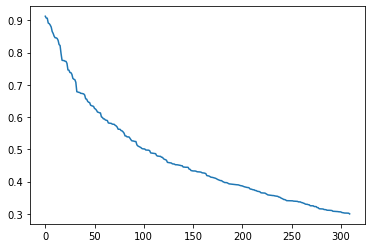

In [34]:
plt.plot(losses)

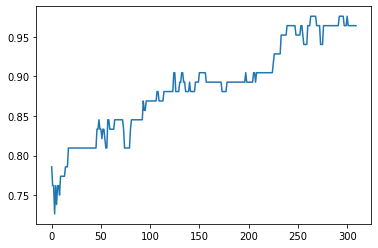

In [35]:
plt.plot(accuracies)

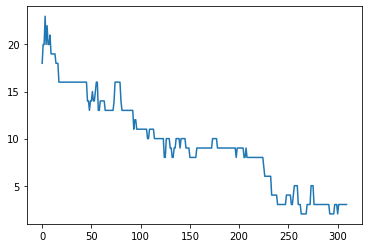

In [36]:
plt.plot(errors)